> In this Demo notebook, I use Pytorch to train a model and then convert it to TFLite. Otherwise, you can train your model with Tensorflow directly. Then you do not need to do conversion: Pytorch->ONNX->TFLite.



`onnx2tf` is a Python package that actively developed to support the conversion from Onnx model to TFlite.


In [2]:
!apt-get -qq install xxd

  Using cached calflops-0.2.9-py3-none-any.whl (30 kB)
  Using cached accelerate-0.28.0-py3-none-any.whl (290 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 847.9 kB/s eta 0:00:00
     ━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/410.6 MB 1.5 MB/s eta 0:03:55
ERROR: Operation cancelled by user


In [13]:
!git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow && pip install -e .
import sys
sys.path.append("./onnx-tensorflow")

Cloning into 'onnx-tensorflow'...
remote: Enumerating objects: 6516, done.
remote: Counting objects: 100% (465/465), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 6516 (delta 326), reused 383 (delta 261), pack-reused 6051
Receiving objects: 100% (6516/6516), 1.98 MiB | 12.00 MiB/s, done.
Resolving deltas: 100% (5051/5051), done.
Obtaining file:///content/onnx-tensorflow
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.7 MB/s eta 0:00:00
  Running setup.py develop for onnx-tf


In [3]:
!sudo apt-get -y update
!sudo apt-get -y install python3-pip
!sudo apt-get -y install python-is-python3
!wget https://github.com/PINTO0309/onnx2tf/releases/download/1.16.31/flatc.tar.gz \
  && tar -zxvf flatc.tar.gz \
  && sudo chmod +x flatc \
  && sudo mv flatc /usr/bin/
!pip install -U pip \
  && pip install tensorflow==2.15.0 \
  && pip install -U onnx==1.15.0 \
  && python -m pip install onnx_graphsurgeon \
        --index-url https://pypi.ngc.nvidia.com \
  && pip install -U onnxruntime==1.16.3 \
  && pip install -U onnxsim==0.4.33 \
  && pip install -U simple_onnx_processing_tools \
  && pip install -U onnx2tf \
  && pip install -U protobuf==3.20.3 \
  && pip install -U h5py==3.7.0 \
  && pip install -U psutil==5.9.5 \
  && pip install -U ml_dtypes==0.2.0

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,104 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,358 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/mai

## Prepare dataset for this Demo


In [4]:
import os
import random
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def load_data(split, dataset_name, datadir, translation=False):
    ## https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151
    if dataset_name == 'MNIST':
        normalize = transforms.Normalize(mean=[0.1307], std=[0.3081])

    if dataset_name == 'FashionMNIST':
        normalize = transforms.Normalize(mean=[0.5], std=[0.5])
        tr_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), normalize])
        val_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), normalize])
    get_dataset = getattr(datasets, dataset_name)
    if split == 'train':
        dataset = get_dataset(root=datadir, train=True, download=True, transform=tr_transform)
    else:
        dataset = get_dataset(root=datadir, train=False, download=True, transform=val_transform)
    return dataset

In [5]:
num_classes = 10
num_channels = 1
train_dataset = load_data("train", "FashionMNIST", "dataset")
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataset = load_data("test", "FashionMNIST", "dataset")
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 16120793.72it/s]


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 275739.45it/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5045201.81it/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21378492.07it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



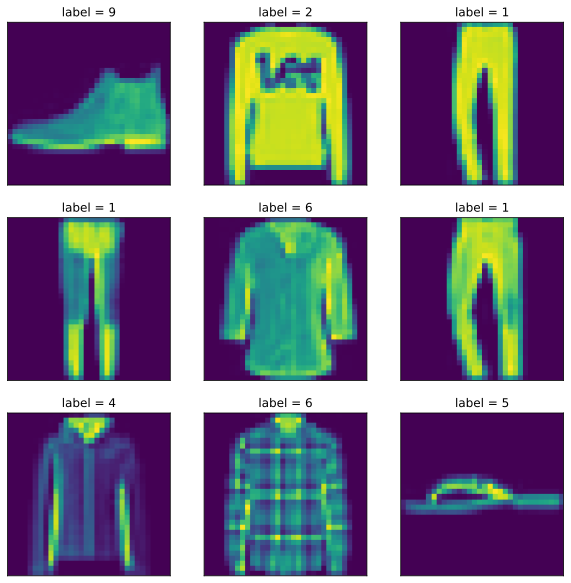

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9):
    img,label = test_dataset[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.cpu().numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [27]:
# img.shape

## Define a simple model

In [7]:
from torch import nn


class LeNet(nn.Module):
    def __init__(self, num_classes=10, num_channels=1):
        super(LeNet, self).__init__()
        self.con_block = nn.Sequential(
            # 3x32x32
            nn.Conv2d(in_channels=num_channels, out_channels=4, kernel_size=5, stride=1),
            # 4x28x28
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 4x14x14
            nn.Conv2d(in_channels=4, out_channels=12, kernel_size=5, stride=1),
            # 12x10x10
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 12x5x5

        )

        self.fc = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(in_features=12 * 5 * 5, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=num_classes),
        )


    def forward(self, x):
        x = self.con_block(x)
        x = self.fc(x)

        return x

## Define Training helpers

In [8]:
from tqdm import tqdm
import random
import torch
import torchvision.transforms.functional as TF
def train(train_loader, model, criterion, optimizer, epoch, device):
    model.train()

    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in tqdm(train_loader, "Training"):
    # for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()


    train_accuracy = 100 * train_correct / train_total
    avg_train_loss = train_loss / len(train_loader)

def test(test_loader, model, criterion, optimizer, epoch, device):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
      for inputs, labels in tqdm(test_loader, "testing"):
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)

          loss = criterion(outputs, labels)
          test_loss += loss.item()

          _, predicted = outputs.max(1)
          test_total += labels.size(0)
          test_correct += (predicted == labels).sum().item()


      test_accuracy = 100 * test_correct / test_total
      avg_test_loss = test_loss / len(test_loader)
      print(f"Epoch {epoch+1}, Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")
      return test_accuracy/100


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = LeNet(num_classes=num_classes, num_channels=num_channels).to(device)
print(model)

lr = 2e-3
epochs = 10
criterion = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
  train(train_loader, model, criterion, optimizer, epoch, device)
  test_accuracy = test(test_loader, model, criterion, optimizer, epoch, device)



cuda
LeNet(
  (con_block): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=300, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=10, bias=True)
  )
)


testing: 100%|██████████| 40/40 [00:03<00:00, 12.13it/s]


Epoch 1, Loss: 0.5442, Test Accuracy: 79.55%



testing: 100%|██████████| 40/40 [00:02<00:00, 14.91it/s]


Epoch 2, Loss: 0.4551, Test Accuracy: 83.67%



testing: 100%|██████████| 40/40 [00:02<00:00, 15.01it/s]


Epoch 3, Loss: 0.4265, Test Accuracy: 84.62%



testing: 100%|██████████| 40/40 [00:02<00:00, 15.18it/s]


Epoch 4, Loss: 0.4065, Test Accuracy: 84.98%



testing: 100%|██████████| 40/40 [00:02<00:00, 13.38it/s]


Epoch 5, Loss: 0.3865, Test Accuracy: 85.75%



testing: 100%|██████████| 40/40 [00:02<00:00, 15.20it/s]


Epoch 6, Loss: 0.3616, Test Accuracy: 87.07%



testing: 100%|██████████| 40/40 [00:02<00:00, 14.90it/s]


Epoch 7, Loss: 0.3612, Test Accuracy: 86.82%



testing: 100%|██████████| 40/40 [00:03<00:00, 12.05it/s]


Epoch 8, Loss: 0.3467, Test Accuracy: 87.47%



testing: 100%|██████████| 40/40 [00:02<00:00, 15.09it/s]


Epoch 9, Loss: 0.3538, Test Accuracy: 87.31%



testing: 100%|██████████| 40/40 [00:02<00:00, 15.06it/s]

Epoch 10, Loss: 0.3433, Test Accuracy: 87.65%



## Model Conversion : pytorch->ONNX->TFLite

In [14]:
import onnx
from onnx import helper
from onnx_tf.backend import prepare

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [31]:
dummy_input = torch.randn(1, 1, 32, 32, dtype=torch.float32)
torch.onnx.export(
        model=model.cpu(),
        args=dummy_input,
        f="model.onnx",
        verbose=False,
        export_params=True,
        do_constant_folding=False,
        input_names=['input'],
        opset_version=11,
        output_names=['output'])
print('ONNX model successfully converted')
onnx_model = onnx.load("model.onnx")

# add softmax # This is because in the defined LeNet, we do not explicitly add SoftMax to model.
last_node_output = onnx_model.graph.node[-1].output[0]
softmax_input = [last_node_output]

softmax_output = last_node_output + "_softmax"
softmax_node = helper.make_node(
    "Softmax",
    inputs=softmax_input,
    outputs=[softmax_output],
    axis=1
)
onnx_model.graph.node.append(softmax_node)
onnx_model.graph.output[0].name = softmax_output
onnx.save(onnx_model, "model.onnx")
# add softmax

onnx.checker.check_model(onnx_model)


ONNX model successfully converted


In [33]:
!onnx2tf -i model.onnx  -v info


Model optimizing started ============================================================
Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃            ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Constant   │ 8              │ 8                │
│ Conv       │ 2              │ 2                │
│ Flatten    │ 1              │ 1                │
│ Gemm       │ 2              │ 2                │
│ MaxPool    │ 2              │ 2                │
│ Relu       │ 3              │ 3                │
│ Softmax    │ 1              │ 1                │
│ Model Size │ 45.9KiB        │ 46.5KiB          │
└────────────┴────────────────┴──────────────────┘

Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃            ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Constant   │ 8              │ 8                │
│ 

In [34]:
!cp saved_model/model_float32.tflite model.tflite

In [35]:
!xxd -i model.tflite > model.h

In [36]:
!tail -n1 model.h

unsigned int model_tflite_len = 48448;


## Sample Data

In [46]:

random_idx = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_idx]
print(f"Label = {label}")
image_array = image.numpy()
image_array = np.squeeze(image_array)
image_list = image_array.flatten().tolist()

Label = 7


In [47]:
c_array_str = ", ".join([str(pixel) for pixel in image_list])

In [48]:
c_array_formatted = f"const float input_data[] = {{\n  {c_array_str}\n}};"

file_path = "data.h"
with open(file_path, 'w') as file:
    file.write(c_array_formatted)

file_path


'data.h'

> Please put `data.h` to arduino folder.